In [45]:
# 단순 눈 좌표 추출( 영상 구분 없이 고정된 프레임 수로 나눔)

import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import math

face_mesh = mp.solutions.face_mesh 
mp_drawing = mp.solutions.drawing_utils 

FACE_2 = [386, 374,263, 362,159, 145,133, 33]

FACE=list(range(468))

LEFT_EYE_TOP_BOTTOM_LEFT_RIGHT = [386, 374,263, 362]
RIGHT_EYE_TOP_BOTTOM_LEFT_RIGHT = [159, 145,133, 33]


def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

def draw_landmark(height, width, outputs, land_mark, color):
    for face in land_mark:
        point = outputs.multi_face_landmarks[0].landmark[face]
        point_scale = ((int)(point.x * width), (int)(point.y * height))

def cal_distance(height, width, camera_point1, camera_point2):
    point1 = int(camera_point1.x * width), int(camera_point1.y * height)
    point2 = int(camera_point2.x * width), int(camera_point2.y * height)
    distance = math.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)
    return distance

def cal_ratio(height,width, outputs, left, right, secant):
    landmark = outputs.multi_face_landmarks[0]
    top1 = landmark.landmark[left[0]]
    bottom1 = landmark.landmark[left[1]]
    top_bottom_dis1 = cal_distance(height,width, top1, bottom1)

    top2 = landmark.landmark[right[0]]
    bottom2 = landmark.landmark[right[1]]
    top_bottom_dis2 = cal_distance(height,width, top2, bottom2)

    lwide1 = landmark.landmark[left[2]]
    rwide1 = landmark.landmark[left[3]]
    lwide_rwide_dis1 = cal_distance(height,width,lwide1, rwide1)

    lwide2 = landmark.landmark[right[2]]
    rwide2 = landmark.landmark[right[3]]
    lwide_rwide_dis2 = cal_distance(height,width,lwide2, rwide2)

    sum_wide = 0
    sum_height = 0

    if lwide_rwide_dis1!=0 and lwide_rwide_dis2 != 0: # 가로 길이 보정
        if lwide_rwide_dis1/lwide_rwide_dis2 > 1.1 or lwide_rwide_dis1 /lwide_rwide_dis2 < 0.9:
            if lwide_rwide_dis1 > lwide_rwide_dis2:
                sum_wide = round(lwide_rwide_dis1/2)*2
            else:
                sum_wide = round(lwide_rwide_dis2/2)*2
        else:
            sum_wide = (round(lwide_rwide_dis1/3)*3+round(lwide_rwide_dis2/3)*3)/2
    
    if top_bottom_dis1 !=0 and top_bottom_dis2 != 0: # 세로 길이 보정
        if top_bottom_dis1/top_bottom_dis2 > 1.1 or top_bottom_dis1/top_bottom_dis2 < 0.9:
            if top_bottom_dis1 > top_bottom_dis2:
                sum_height = round(top_bottom_dis1/2)*2
            else:
                sum_height = round(top_bottom_dis2/2)*2
        else:
            sum_height =(round(top_bottom_dis1/2)*2+round(top_bottom_dis2/2)*2)/2
    
    secant_u = math.ceil(secant*100)/100
    secant_d = math.floor(secant*100)/100
    aspect_ratio = round((round((sum_height*secant_u*secant_u*secant_u)/(sum_wide*secant_d*secant_d)/2, 3)
                        * 2 + round((sum_height*secant_u*secant_u*secant_u)/(sum_wide*secant_d*secant_d)/5, 2)*5) /2, 4)

    cv2.putText(image, "ratio: " + str(aspect_ratio), (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    return aspect_ratio

def get_3D(height, width, outputs, landmark):
    face_3d = []
    face_2d = []

    for face in landmark:
        point = outputs.multi_face_landmarks[0].landmark[face]
        x, y = int(point.x * width), int(point.y * height)
        face_2d.append([x, y])
        face_3d.append([x, y, point.z])       

    face_2d = np.array(face_2d, dtype=np.float64)
    face_3d = np.array(face_3d, dtype=np.float64)
    focal_length = width
    cam_matrix = np.array([ [focal_length, 0, height / 2],
                            [0, focal_length, width / 2],
                            [0, 0, 1]])
    dist_matrix = np.zeros((4, 1), dtype=np.float64)
    success, rot_vec, trans_vec = cv2.solvePnP(face_3d, face_2d, cam_matrix, dist_matrix)
    rmat, jac = cv2.Rodrigues(rot_vec)
    angles, mtxR, mtxQ, Qx, Qy, Qz = cv2.RQDecomp3x3(rmat)
    x = angles[0] * 360 * math.pi * 0.7+7
    
    x = np.round(x,1)
    cv2.putText(image, "pitch: " + str(x), (100, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    if x > 40 :
        x = 40
    elif x <-40:
        x = -40 
    return x

def extract_keypoints(results , landmarknum):
    face_e = np.array([])
    # 코 위치
    point = results.multi_face_landmarks[0].landmark[1]
    vector = [point.x, point.y, point.z]
    
    # 코를 중심으로 눈 위치 재정렬
    for face in landmarknum:
        point = results.multi_face_landmarks[0].landmark[face]
        face_e = np.append(face_e, np.array([point.x - vector[0], point.y - vector[1], point.z- vector[2]]).flatten())  
    return face_e # 478*3(x,y,z)


# Path for exported data, numpy arrays
DATA_PATH = os.path.join('D:\새 폴더\python-workspace\sign','MP_Data14_ratio_variance_angle_300+') 

# 분류 갯수
actions = np.array(['normal','drowsy'])
# 한 영상당 프레임 수
sequence_length = 300

# 폴더 만들기
for action in actions: 
    try: 
        os.makedirs(os.path.join(DATA_PATH, action))
    except:
        pass
for jj in range(1,3):
    for i in range(1,16):
        print("real",i)
        a =str(i)+"_"+str(jj)+".mp4"
        ## 영상 입력
        name = a

        ## 영상 이름 인식
        if(name[1]!='_'):
            im = name[0]+name[1]
            print(im)    
            sequence = int(im) # '1_2.mp4' 에서 '1' -> 비디오 순서
            if int(name[3]) - 1 == 0:
                action = actions[0] # '1_2.mp4' 에서 '2' -> 비디오 분류(normal or drowsy)
            else:
                action = actions[1]
        else:
            sequence = int(name[0]) # '1_2.mp4' 에서 '1' -> 비디오 순서
            if int(name[2]) - 1 == 0:
                action = actions[0] # '1_2.mp4' 에서 '2' -> 비디오 분류(normal or drowsy)
            else:
                action = actions[1]

        cap = cv2.VideoCapture(name)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        print(frame_count)
        frame_count_num = int(frame_count-sequence_length+1) # 총 프레임/ 필요한 프레임 = 처리 횟수
        print(frame_count_num)
        fps2 = cap.get(cv2.CAP_PROP_FPS)
        prev_time = 0
        face_model = face_mesh.FaceMesh(max_num_faces= 1,
                                    refine_landmarks=True,
                                    min_detection_confidence=0.5,
                                    min_tracking_confidence=0.5)
        
        array = np.empty((0,3))
        sub_ratio = np.array([])
        for i in range(frame_count_num): # 총 프레임/ 필요한 프레임 = 처리 횟수
            print("frame_count_num(unit : 300 frame)",i)
            ratio_variance = []
            get_face_angle_variance = []
            temp = 0
            if i == 0:
                for frame_num in range(sequence_length):
                    ret, frame = cap.read()
                    height, width = frame.shape[:2]
                    image, results = mediapipe_detection(frame, face_model)
                    if results.multi_face_landmarks:

                        draw_landmark(height, width,results, LEFT_EYE_TOP_BOTTOM_LEFT_RIGHT, (0,0,255))
                        draw_landmark(height, width,results, RIGHT_EYE_TOP_BOTTOM_LEFT_RIGHT, (0,0,255))

                        get_face_angle = get_3D(height, width,results,FACE)
                        th = math.radians(get_face_angle)
                        secant = 1.0/math.cos(th)
                        ratio =  cal_ratio(height, width,results, LEFT_EYE_TOP_BOTTOM_LEFT_RIGHT, RIGHT_EYE_TOP_BOTTOM_LEFT_RIGHT,secant)
                        if ratio == 0:
                            ratio = 0.001
                            
                        ratio_variance.append(ratio)
                        get_face_angle_variance.append(get_face_angle)
                        if len(ratio_variance) >= 2 and ratio_variance[0] != 0 and ratio_variance[1] != 0:
                            ratio_variance_change = ratio_variance[-2] - ratio_variance[-1]
                            if (ratio_variance_change<0.012 and ratio_variance_change>-0.012):
                                ratio_variance_change = 0

                            mul2 = 0
                            if ratio_variance_change > 0 and temp ==0:
                                mul2 = ratio_variance_change / ratio_variance[-2]
                                temp = ratio_variance[-2]
                            elif ratio_variance_change > 0 and temp !=0:
                                mul2 = ratio_variance_change / temp
                            else:
                                mul2 = ratio_variance_change / ratio_variance[-1]
                                temp = 0
                            
                            mul3 = 0
                            get_face_angle_variance_change = get_face_angle_variance[-2] - get_face_angle_variance[-1]
                            if get_face_angle_variance_change <= 1 and get_face_angle_variance_change >= -1:
                                get_face_angle_variance_change = 0

                            if mul2 <= 0.24 and mul2 >= 0 and get_face_angle_variance_change > 0:  
                                mul3 = get_face_angle_variance_change

                            input_data = np.array([ratio,mul2,mul3])
                            # 인식 실패시 사용할 임시 ratio
                            sub_ratio = input_data

                            npy_path = os.path.join(DATA_PATH, action, (str(sequence)+"_"+str(i)+"_"+str(frame_num)))
                            np.save(npy_path, input_data)
                            array = np.append(array,np.array([input_data]),axis=0)
                    else :
                        print("인식 실패")
                        # 얼굴 인식 실패했기 때문에 데이터 개수를 맞추기 위해 이전 데이터를 복사해서 저장한다.
                        npy_path = os.path.join(DATA_PATH, action, (str(sequence)+"_"+str(i)+"_"+str(frame_num)))
                        np.save(npy_path, sub_ratio)
                        array = np.append(array,np.array([sub_ratio]),axis=0)
            else:
                ret, frame = cap.read()
                height, width = frame.shape[:2]
                # Make detections
                image, results = mediapipe_detection(frame, face_model)
                if results.multi_face_landmarks:

                    draw_landmark(height, width,results, LEFT_EYE_TOP_BOTTOM_LEFT_RIGHT, (0,0,255))
                    draw_landmark(height, width,results, RIGHT_EYE_TOP_BOTTOM_LEFT_RIGHT, (0,0,255))

                    get_face_angle = get_3D(height, width,results,FACE)
                    th = math.radians(get_face_angle)
                    secant = 1.0/math.cos(th)
                    ratio =  cal_ratio(height, width,results, LEFT_EYE_TOP_BOTTOM_LEFT_RIGHT, RIGHT_EYE_TOP_BOTTOM_LEFT_RIGHT,secant)
                    if ratio == 0:
                        ratio = 0.001
                        
                    ratio_variance.append(ratio)
                    get_face_angle_variance.append(get_face_angle)
                    if len(ratio_variance) >= 2 and ratio_variance[0] != 0 and ratio_variance[1] != 0:
                        ratio_variance_change = ratio_variance[-2] - ratio_variance[-1]
                        if (ratio_variance_change<0.012 and ratio_variance_change>-0.012):
                            ratio_variance_change = 0

                        mul2 = 0
                        if ratio_variance_change > 0 and temp ==0:
                            mul2 = ratio_variance_change / ratio_variance[-2]
                            temp = ratio_variance[-2]
                        elif ratio_variance_change > 0 and temp !=0:
                            mul2 = ratio_variance_change / temp
                        else:
                            mul2 = ratio_variance_change / ratio_variance[-1]
                            temp = 0
                        
                        mul3 = 0
                        get_face_angle_variance_change = get_face_angle_variance[-2] - get_face_angle_variance[-1]
                        if get_face_angle_variance_change <= 1 and get_face_angle_variance_change >= -1:
                            get_face_angle_variance_change = 0

                        if mul2 <= 0.24 and mul2 >= 0 and get_face_angle_variance_change > 0:  
                            mul3 = get_face_angle_variance_change

                        input_data = np.array([ratio,mul2,mul3])
                        # 인식 실패시 사용할 임시 ratio
                        sub_ratio = input_data

                        array = np.delete(array,0,0)
                        array = np.append(array,np.array([input_data]),axis=0)
                        for frame_num in range(1, array.shape[0]):
                            npy_path = os.path.join(DATA_PATH, action, (str(sequence)+"_"+str(i)+"_"+str(frame_num)))
                            np.save(npy_path, array[frame_num])

                else :
                    print("인식 실패")
                    array = np.delete(array,0,0)
                    array = np.append(array,np.array([sub_ratio]),axis=0)
                    for frame_num in range(array.shape[0]):
                        npy_path = os.path.join(DATA_PATH, action, (str(sequence)+"_"+str(i)+"_"+str(frame_num)))
                        np.save(npy_path, array[frame_num])

            cv2.imshow('OpenCV Feed', image)
            if (cv2.waitKey(10) & 0xFF == ord('q')):
                break
                
        cap.release()
        cv2.destroyAllWindows()

real 1
1823
1524
frame_count_num(unit : 300 frame) 0
frame_count_num(unit : 300 frame) 1
frame_count_num(unit : 300 frame) 2
frame_count_num(unit : 300 frame) 3
frame_count_num(unit : 300 frame) 4
frame_count_num(unit : 300 frame) 5
frame_count_num(unit : 300 frame) 6
frame_count_num(unit : 300 frame) 7
frame_count_num(unit : 300 frame) 8
frame_count_num(unit : 300 frame) 9
frame_count_num(unit : 300 frame) 10
frame_count_num(unit : 300 frame) 11
frame_count_num(unit : 300 frame) 12
frame_count_num(unit : 300 frame) 13
frame_count_num(unit : 300 frame) 14
frame_count_num(unit : 300 frame) 15
frame_count_num(unit : 300 frame) 16
frame_count_num(unit : 300 frame) 17
frame_count_num(unit : 300 frame) 18
frame_count_num(unit : 300 frame) 19
frame_count_num(unit : 300 frame) 20
frame_count_num(unit : 300 frame) 21
frame_count_num(unit : 300 frame) 22
frame_count_num(unit : 300 frame) 23
frame_count_num(unit : 300 frame) 24
frame_count_num(unit : 300 frame) 25
frame_count_num(unit : 300 fram

KeyboardInterrupt: 

In [40]:
# a = np.array([])
b = np.array([4,2,3])
# c = np.block([[a],[b]])
array = np.empty((0,3))
array = np.append(array,[b],axis=0)
array = np.append(array,np.array([[1,2,3]]),axis=0)
array = np.append(array,np.array([[1,2,3]]),axis=0)
array = np.delete(array,0,0)

c = np.array([43,2,3])
array = np.append(array,np.array([c]),axis=0)
array = np.append(array,np.array([c]),axis=0)
array.shape[0]



4

In [12]:
# 단순 눈 좌표 추출( 영상 구분 없이 고정된 프레임 수로 나눔)

import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import math

face_mesh = mp.solutions.face_mesh 
mp_drawing = mp.solutions.drawing_utils 

FACE_2 = [386, 374,263, 362,159, 145,133, 33]

FACE=list(range(468))

LEFT_EYE_TOP_BOTTOM_LEFT_RIGHT = [386, 374,263, 362]
RIGHT_EYE_TOP_BOTTOM_LEFT_RIGHT = [159, 145,133, 33]


def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    image.flags.writeable = False                  
    results = model.process(image)                 
    image.flags.writeable = True                   
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 

def draw_landmark(height, width, outputs, land_mark, color):
    for face in land_mark:
        point = outputs.multi_face_landmarks[0].landmark[face]
        point_scale = ((int)(point.x * width), (int)(point.y * height))
        cv2.circle(image, point_scale, 2, color, 1)
# def extract_keypoints(results , landmarknum):
#     face_e = np.array([])
#     # 코 위치
#     point = results.multi_face_landmarks[0].landmark[1]
#     vector = [point.x, point.y, point.z]
    
#     # 코를 중심으로 눈 위치 재정렬
#     for face in landmarknum:
#         point = results.multi_face_landmarks[0].landmark[face]
#         face_e = np.append(face_e, np.array([point.x - vector[0], point.y - vector[1], point.z- vector[2]]).flatten())  
#     return face_e # 478*3(x,y,z)

def cal_distance(height, width, camera_point1, camera_point2):
    point1 = int(camera_point1.x * width), int(camera_point1.y * height)
    point2 = int(camera_point2.x * width), int(camera_point2.y * height)
    distance = math.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)
    return distance

# def cal_ratio(height,width, outputs, top_bottom, left_right, secant):
#     landmark = outputs.multi_face_landmarks[0]
#     top = landmark.landmark[top_bottom[0]]
#     bottom = landmark.landmark[top_bottom[1]]
#     top_bottom_dis = cal_distance(height,width, top, bottom)
#     top_bottom_dis = top_bottom_dis * secant
#     left = landmark.landmark[left_right[0]]
#     right = landmark.landmark[left_right[1]]
#     left_right_dis = cal_distance(height,width,left, right)
#     aspect_ratio = top_bottom_dis / left_right_dis
#     return aspect_ratio

def cal_ratio(height,width, outputs, left, right, secant):
    landmark = outputs.multi_face_landmarks[0]
    top1 = landmark.landmark[left[0]]
    bottom1 = landmark.landmark[left[1]]
    top_bottom_dis1 = cal_distance(height,width, top1, bottom1)

    top2 = landmark.landmark[right[0]]
    bottom2 = landmark.landmark[right[1]]
    top_bottom_dis2 = cal_distance(height,width, top2, bottom2)

    lwide1 = landmark.landmark[left[2]]
    rwide1 = landmark.landmark[left[3]]
    lwide_rwide_dis1 = cal_distance(height,width,lwide1, rwide1)

    lwide2 = landmark.landmark[right[2]]
    rwide2 = landmark.landmark[right[3]]
    lwide_rwide_dis2 = cal_distance(height,width,lwide2, rwide2)

    sum_wide = 0
    sum_height = 0

    if lwide_rwide_dis1!=0 and lwide_rwide_dis2 != 0: # 가로 길이 보정
        if lwide_rwide_dis1/lwide_rwide_dis2 > 1.1 or lwide_rwide_dis1 /lwide_rwide_dis2 < 0.9:
            if lwide_rwide_dis1 > lwide_rwide_dis2:
                sum_wide = round(lwide_rwide_dis1/2)*2
            else:
                sum_wide = round(lwide_rwide_dis2/2)*2
        else:
            sum_wide = (round(lwide_rwide_dis1/3)*3+round(lwide_rwide_dis2/3)*3)/2
    
    if top_bottom_dis1 !=0 and top_bottom_dis2 != 0: # 세로 길이 보정
        if top_bottom_dis1/top_bottom_dis2 > 1.1 or top_bottom_dis1/top_bottom_dis2 < 0.9:
            if top_bottom_dis1 > top_bottom_dis2:
                sum_height = round(top_bottom_dis1/2)*2
            else:
                sum_height = round(top_bottom_dis2/2)*2
        else:
            sum_height =(round(top_bottom_dis1/2)*2+round(top_bottom_dis2/2)*2)/2
    
    secant_u = math.ceil(secant*100)/100
    secant_d = math.floor(secant*100)/100
    aspect_ratio = round((round((sum_height*secant_u*secant_u*secant_u)/(sum_wide*secant_d*secant_d)/2, 3)
                        * 2 + round((sum_height*secant_u*secant_u*secant_u)/(sum_wide*secant_d*secant_d)/5, 2)*5) /2, 4)

    # aspect_ratio = round(sum_height/sum_wide/2*secant,2)*2
    cv2.putText(image, "ratio: " + str(aspect_ratio), (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    return aspect_ratio

def get_3D(height, width, outputs, landmark):
    face_3d = []
    face_2d = []

    for face in landmark:
        point = outputs.multi_face_landmarks[0].landmark[face]
        x, y = int(point.x * width), int(point.y * height)
        face_2d.append([x, y])
        face_3d.append([x, y, point.z])       

    face_2d = np.array(face_2d, dtype=np.float64)
    face_3d = np.array(face_3d, dtype=np.float64)
    focal_length = width
    cam_matrix = np.array([ [focal_length, 0, height / 2],
                            [0, focal_length, width / 2],
                            [0, 0, 1]])
    dist_matrix = np.zeros((4, 1), dtype=np.float64)
    success, rot_vec, trans_vec = cv2.solvePnP(face_3d, face_2d, cam_matrix, dist_matrix)
    rmat, jac = cv2.Rodrigues(rot_vec)
    angles, mtxR, mtxQ, Qx, Qy, Qz = cv2.RQDecomp3x3(rmat)
    x = angles[0] * 360 * math.pi * 0.7+7
    
    x = np.round(x,1)
    cv2.putText(image, "pitch: " + str(x), (100, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    if x > 40 :
        x = 40
    elif x <-40:
        x = -40 
    return x

def extract_keypoints(results , landmarknum):
    face_e = np.array([])
    # 코 위치
    point = results.multi_face_landmarks[0].landmark[1]
    vector = [point.x, point.y, point.z]
    
    # 코를 중심으로 눈 위치 재정렬
    for face in landmarknum:
        point = results.multi_face_landmarks[0].landmark[face]
        face_e = np.append(face_e, np.array([point.x - vector[0], point.y - vector[1], point.z- vector[2]]).flatten())  
    return face_e # 478*3(x,y,z)


# Path for exported data, numpy arrays
DATA_PATH = os.path.join('D:\새 폴더\python-workspace\sign','MP_Data15_ratio_variance_angle_99') 

# 분류 갯수
actions = np.array(['normal','drowsy'])
# 한 영상당 프레임 수
sequence_length = 100

# 폴더 만들기
for action in actions: 
    try: 
        os.makedirs(os.path.join(DATA_PATH, action))
    except:
        pass
for jj in range(1,3):
    for i in range(1,31):
        print("real",i)
        a =str(i)+"_"+str(jj)+".mp4"
        ## 영상 입력
        name = a

        ## 영상 이름 인식
        if(name[1]!='_'):
            im = name[0]+name[1]
            print(im)    
            sequence = int(im) # '1_2.mp4' 에서 '1' -> 비디오 순서
            if int(name[3]) - 1 == 0:
                action = actions[0] # '1_2.mp4' 에서 '2' -> 비디오 분류(normal or drowsy)
            else:
                action = actions[1]
        else:
            sequence = int(name[0]) # '1_2.mp4' 에서 '1' -> 비디오 순서
            if int(name[2]) - 1 == 0:
                action = actions[0] # '1_2.mp4' 에서 '2' -> 비디오 분류(normal or drowsy)
            else:
                action = actions[1]

        cap = cv2.VideoCapture(name)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        print(frame_count)
        frame_count_num = int(frame_count//sequence_length) # 총 프레임/ 필요한 프레임 = 처리 횟수
        print(frame_count_num)
        fps2 = cap.get(cv2.CAP_PROP_FPS)
        prev_time = 0
        face_model = face_mesh.FaceMesh(max_num_faces= 1,
                                    refine_landmarks=True,
                                    min_detection_confidence=0.5,
                                    min_tracking_confidence=0.5)
        
     
        for i in range(frame_count_num): # 총 프레임/ 필요한 프레임 = 처리 횟수
            print("frame_count_num(unit : 300 frame)",i)
            sub_ratio = np.array([]) # 얼굴 인식을 실패한 프레임에 복사한 이전 얼굴 데이터를 저장하기 위함(데이터를 임시로 복사한 값을 저장하기 위한 변수)
            ratio_variance = []
            get_face_angle_variance = []
            temp = 0
            for frame_num in range(sequence_length):
                # Read feed
                ret, frame = cap.read()
                height, width = frame.shape[:2]
                # Make detections
                image, results = mediapipe_detection(frame, face_model)
                if results.multi_face_landmarks:

                    draw_landmark(height, width,results, LEFT_EYE_TOP_BOTTOM_LEFT_RIGHT, (0,0,255))
                    draw_landmark(height, width,results, RIGHT_EYE_TOP_BOTTOM_LEFT_RIGHT, (0,0,255))

                    get_face_angle = get_3D(height, width,results,FACE)
                    th = math.radians(get_face_angle)
                    secant = 1.0/math.cos(th)

                    # ratio_left =  cal_ratio(height, width,outputs, LEFT_EYE_TOP_BOTTOM, LEFT_EYE_LEFT_RIGHT,secant)
                    # ratio_right =  cal_ratio(height, width,outputs, RIGHT_EYE_TOP_BOTTOM, RIGHT_EYE_LEFT_RIGHT,secant)
                    # ratio = (ratio_left + ratio_right)/2.0
                    ratio =  cal_ratio(height, width,results, LEFT_EYE_TOP_BOTTOM_LEFT_RIGHT, RIGHT_EYE_TOP_BOTTOM_LEFT_RIGHT,secant)
                    if ratio == 0:
                        ratio = 0.001
                        
                    ratio_variance.append(ratio)
                    get_face_angle_variance.append(get_face_angle)
                    if len(ratio_variance) >= 2 and ratio_variance[0] != 0 and ratio_variance[1] != 0:
                        ratio_variance_change = ratio_variance[-2] - ratio_variance[-1]
                        if (ratio_variance_change<0.012 and ratio_variance_change>-0.012):
                            ratio_variance_change = 0

                        mul2 = 0
                        if ratio_variance_change > 0 and temp ==0:
                            mul2 = ratio_variance_change / ratio_variance[-2]
                            temp = ratio_variance[-2]
                        elif ratio_variance_change > 0 and temp !=0:
                            mul2 = ratio_variance_change / temp
                        else:
                            mul2 = ratio_variance_change / ratio_variance[-1]
                            temp = 0
                        
                        mul3 = 0
                        get_face_angle_variance_change = get_face_angle_variance[-2] - get_face_angle_variance[-1]
                        if get_face_angle_variance_change <= 1 and get_face_angle_variance_change >= -1:
                            get_face_angle_variance_change = 0

                        if mul2 <= 0.24 and mul2 >= 0 and get_face_angle_variance_change > 0:  
                            mul3 = get_face_angle_variance_change

                        # 값이 너무 작으므로 차이를 극대화 시키기 위함
                        input_data = np.array([ratio,mul2,mul3])
                        # 인식 실패시 사용할 임시 ratio
                        sub_ratio = input_data

                        npy_path = os.path.join(DATA_PATH, action, (str(sequence)+"_"+str(i)+"_"+str(frame_num)))
                        np.save(npy_path, input_data)

                else :
                    print("인식 실패")
                    # 얼굴 인식 실패했기 때문에 데이터 개수를 맞추기 위해 이전 데이터를 복사해서 저장한다.
                    npy_path = os.path.join(DATA_PATH, action, (str(sequence)+"_"+str(i)+"_"+str(frame_num)))
                    np.save(npy_path, sub_ratio)
                cv2.imshow('OpenCV Feed', image)
                if (cv2.waitKey(10) & 0xFF == ord('q')):
                    break
                
        cap.release()
        cv2.destroyAllWindows()

real 1
1823
18
frame_count_num(unit : 300 frame) 0
frame_count_num(unit : 300 frame) 1
frame_count_num(unit : 300 frame) 2
frame_count_num(unit : 300 frame) 3
frame_count_num(unit : 300 frame) 4
frame_count_num(unit : 300 frame) 5
frame_count_num(unit : 300 frame) 6
frame_count_num(unit : 300 frame) 7
frame_count_num(unit : 300 frame) 8
frame_count_num(unit : 300 frame) 9
frame_count_num(unit : 300 frame) 10
frame_count_num(unit : 300 frame) 11
frame_count_num(unit : 300 frame) 12
frame_count_num(unit : 300 frame) 13
frame_count_num(unit : 300 frame) 14
frame_count_num(unit : 300 frame) 15
frame_count_num(unit : 300 frame) 16
frame_count_num(unit : 300 frame) 17
real 2
1819
18
frame_count_num(unit : 300 frame) 0
frame_count_num(unit : 300 frame) 1
frame_count_num(unit : 300 frame) 2
frame_count_num(unit : 300 frame) 3
frame_count_num(unit : 300 frame) 4
frame_count_num(unit : 300 frame) 5
frame_count_num(unit : 300 frame) 6
frame_count_num(unit : 300 frame) 7
frame_count_num(unit : 300

In [15]:
# 영상 개수 구분 없는 코드(영상을 고정된 프레임으로 나눈 것)

import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard

# 졸음, 안졸음으로 구분
actions = np.array(['normal','drowsy'])
# 99 프레임
sequence_length = 99
# label_map = {'normal': 0, 'drowsy': 1}
label_map = {label:num for num, label in enumerate(actions)}
# 5개(10초짜리)의 비디오, 2개의 폴더
sequences, labels = [], []

def for_sort(x):
    x = x[:-4].split('_')
    return int(x[0]), int(x[1]), int(x[2])

# 폴더에서 꺼내오기
bin1 = []
bin2 = [] 

DATA_PATH = os.path.join('D:\새 폴더\python-workspace\sign', 'MP_Data15_ratio_variance_angle_99')
DATA_PATH_2 = os.path.join('D:\새 폴더\python-workspace\sign\MP_Data15_ratio_variance_angle_99', 'normal')
bin1 = os.listdir(DATA_PATH_2)
# 데이터 순서대로 정렬
bin1.sort(key=for_sort)

DATA_PATH_2 = os.path.join('D:\새 폴더\python-workspace\sign\MP_Data15_ratio_variance_angle_99', 'drowsy')
bin2 = os.listdir(DATA_PATH_2)
bin2.sort(key=for_sort)

repeat_count = int(len(bin2) / sequence_length) # 반복 횟수(파일 개수 / 100(프레임 수))
print(int(len(bin1) / sequence_length))
print(len(bin2))
print(int(len(bin2) / sequence_length))

# sample = np.load(os.path.join(DATA_PATH,'drowsy', '1_0_0.npy'))
# print(len(sample))
#((sequence_length-1)*i),(sequence_length-1)*(i+1)

res1 = list(bin1)
for i in range(repeat_count):
    window = []
    for frame_num in range(sequence_length): # 저장된 프레임 별 데이터를 하나씩 로드함 # 10번 반복(영상 프레임 수)
        res_2 = np.load(os.path.join(DATA_PATH,'normal', str(res1[frame_num+1])))
        window.append(res_2) # window = 한 영상 총 프레임 데이터
    sequences.append(window) # sequence = 5개 영상에 들어있는, 모든 프레임 데이터
    labels.append(label_map['normal']) # 2개의 폴더(분류 개수), 각 폴더마다 5개의 영상을 표시 0000011111
print(len(sequences))

res2 = list(bin2)
for i in range(repeat_count):
    window = []
    for frame_num in range(sequence_length): 
        res_2 = np.load(os.path.join(DATA_PATH,'drowsy', str(res2[frame_num+1])))
        window.append(res_2) # window = 한 영상 총 프레임 데이터
    sequences.append(window) # sequence = 5개 영상에 들어있는, 모든 프레임 데이터
    labels.append(label_map['drowsy']) # 2개의 폴더(분류 개수), 각 폴더마다 5개의 영상을 표시 0000011111
print(len(sequences))
# sequences = sequences[:310]
# # 폴더에서 꺼내오기
# for action in actions: # 2번 반복(분류 갯수)
#     for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int): # 5번 반복(영상 수)
#     for idx, lm in enumerate(actions):
#         window = []
#         for frame_num in range(sequence_length): # 저장된 프레임 별 데이터를 하나씩 로드함 # 10번 반복(영상 프레임 수)
#             res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
#             window.append(res) # window = 한 영상 총 프레임 데이터
#         sequences.append(window) # sequence = 5개 영상에 들어있는, 모든 프레임 데이터
#         labels.append(label_map[action]) # 2개의 폴더(분류 개수), 각 폴더마다 5개의 영상을 표시 0000011111

log_dir = os.path.join('D:\새 폴더\python-workspace\sign','Logs')
tb_callback = TensorBoard(log_dir=log_dir)

# (3개의 영상을 100프레임으로 나눈 영상의 수, 100, 171)
X = np.array(sequences)
print(X.shape)

# (3개의 영상을 100프레임으로 나눈 영상의 수, 2)
y = to_categorical(labels).astype(int) #
print(y.shape) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

X_train = X_train[:620,:,:]
y_train = y[:620,:]
print(X_train.shape)
print(y_train.shape)

503
47817
483
483
966
(966, 99, 3)
(966, 2)
(620, 99, 3)
(620, 2)


In [3]:
# 영상 개수(27or 30개) 폴더 구분된 데이터

import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard

DATA_PATH = os.path.join('D:\\abc','MP_Data_4(past.ratio-present.ratio)') 
actions = np.array(['normal','drowsy'])
sequence_length = 450
# label_map = {'normal': 0, 'drowsy': 1}
label_map = {label:num for num, label in enumerate(actions)}
# 5개(1초짜리)의 비디오, 2개의 폴더
sequences, labels = [], []

for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        print(len(sequences),action)
        labels.append(label_map[action])

log_dir = os.path.join('D:\\abc','Logs')
tb_callback = TensorBoard(log_dir=log_dir)

# (3개의 영상을 100프레임으로 나눈 영상의 수, 100, 171)
X = np.array(sequences)
print(X.shape)

# (3개의 영상을 100프레임으로 나눈 영상의 수, 2)
y = to_categorical(labels).astype(int) #
print(y.shape) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)
print(X_train.shape)

1 normal
2 normal
3 normal
4 normal
5 normal
6 normal
7 normal
8 normal
9 normal
10 normal
11 normal
12 normal
13 normal
14 normal
15 normal
16 normal
17 normal
18 normal
19 normal
20 normal
21 normal
22 normal
23 normal
24 normal
25 normal
26 normal
27 normal
28 normal
29 normal
30 normal
31 drowsy
32 drowsy
33 drowsy
34 drowsy
35 drowsy
36 drowsy
37 drowsy
38 drowsy
39 drowsy
40 drowsy
41 drowsy
42 drowsy
43 drowsy
44 drowsy
45 drowsy
46 drowsy
47 drowsy
48 drowsy
49 drowsy
50 drowsy
51 drowsy
52 drowsy
53 drowsy
54 drowsy
55 drowsy
56 drowsy
57 drowsy
58 drowsy
59 drowsy
60 drowsy
(60, 450, 2)
(60, 2)
(57, 450, 2)


In [24]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import optimizers

model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(99,3))) #return_sequences = 시퀀스 출력 여부
model.add(LSTM(64, return_sequences= False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(actions.shape[0], activation='softmax'))
Adam = optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=Adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train, epochs=150, shuffle = False, callbacks=[tb_callback])
res = model.predict(X_test)

model.save('action_27.h5')
# del model

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 99, 64)            17408     
                                                                 
 lstm_27 (LSTM)              (None, 64)                33024     
                                                                 
 dense_49 (Dense)            (None, 64)                4160      
                                                                 
 dropout_36 (Dropout)        (None, 64)                0         
                                                                 
 dense_50 (Dense)            (None, 2)                 130       
                                                                 
Total params: 54,722
Trainable params: 54,722
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
20/20 [==============================

KeyboardInterrupt: 

dict_keys(['loss', 'accuracy'])


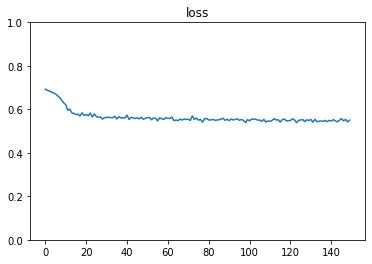

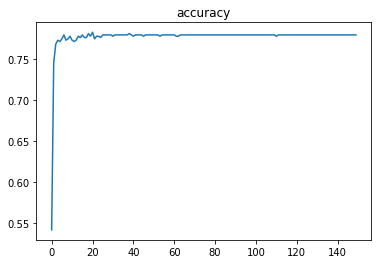

0.40816326530612246


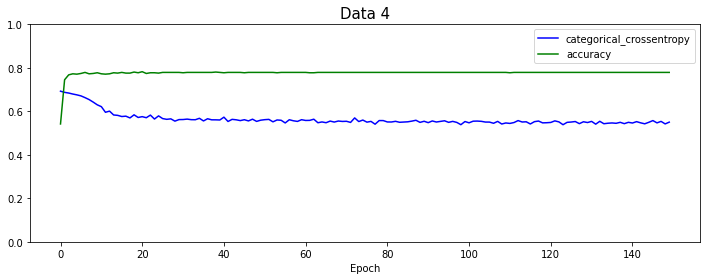

In [23]:
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import optimizers
from matplotlib import pyplot as plt

actions = np.array(['normal','drowsy'])
# action21(150)
# model = Sequential()
# model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(149,2))) #return_sequences = 시퀀스 출력 여부
# model.add(LSTM(128, return_sequences=True, activation='relu'))
# model.add(LSTM(64, return_sequences=False, activation='relu'))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(actions.shape[0], activation='softmax'))
# Adam = optimizers.Adam(learning_rate=0.0001)
# model.compile(optimizer=Adam, loss='categorical_crossentropy', metrics=['accuracy'])

# # action22(150)
# model = Sequential()
# model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(149,2))) #return_sequences = 시퀀스 출력 여부
# model.add(LSTM(128, return_sequences=True, activation='relu'))
# model.add(LSTM(64, return_sequences=False, activation='relu'))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(actions.shape[0], activation='softmax'))
# Adam = optimizers.Adam(learning_rate=0.0001)
# model.compile(optimizer=Adam, loss='categorical_crossentropy', metrics=['accuracy'])

# # action23(MP_Data12_ratio_variance_angle_240)
# model = Sequential()
# model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(209,3))) #return_sequences = 시퀀스 출력 여부
# model.add(LSTM(128, return_sequences=True, activation='relu'))
# model.add(LSTM(64, return_sequences=False, activation='relu'))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(actions.shape[0], activation='softmax'))
# Adam = optimizers.Adam(learning_rate=0.0002)
# model.compile(optimizer=Adam, loss='categorical_crossentropy', metrics=['accuracy'])

# # action24(MP_Data14_ratio_variance_angle_60)
# model = Sequential()
# model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(59,3))) #return_sequences = 시퀀스 출력 여부
# model.add(LSTM(64, return_sequences= False, activation='relu'))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(actions.shape[0], activation='softmax'))
# Adam = optimizers.Adam(learning_rate=0.0001)
# model.compile(optimizer=Adam, loss='categorical_crossentropy', metrics=['accuracy'])

# # action_25(MP_Data10_ratio_variance_240)
# model = Sequential()
# model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(239,2))) #return_sequences = 시퀀스 출력 여부
# model.add(LSTM(128, return_sequences=True, activation='relu'))
# model.add(LSTM(64, return_sequences= False, activation='relu'))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(actions.shape[0], activation='softmax'))
# Adam = optimizers.Adam(learning_rate=0.0001)
# model.compile(optimizer=Adam, loss='categorical_crossentropy', metrics=['accuracy'])

# # action26
# model = Sequential()
# model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(59,3))) #return_sequences = 시퀀스 출력 여부
# model.add(LSTM(64, return_sequences= False, activation='relu'))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(actions.shape[0], activation='softmax'))
# Adam = optimizers.Adam(learning_rate=0.0001)
# model.compile(optimizer=Adam, loss='categorical_crossentropy', metrics=['accuracy'])

# action27
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(99,3))) #return_sequences = 시퀀스 출력 여부
model.add(LSTM(64, return_sequences= False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(actions.shape[0], activation='softmax'))
Adam = optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=Adam, loss='categorical_crossentropy', metrics=['accuracy'])

print(history.history.keys())
plt.plot(history.history['loss'])
plt.title('loss')
plt.ylim([0,1])
plt.show()
plt.plot(history.history['accuracy'])
plt.title('accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure(figsize=(12, 4))
plt.title('Data 4', fontsize= 15)
plt.ylim([0, 1])     # Y축의 범위: [ymin, ymax]
plt.plot(history.history['loss'], 'b-', label='categorical_crossentropy')
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show

# test 데이터

model.load_weights('action_27.h5')
yhat = model.predict(X_test)

ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

multilabel_confusion_matrix(ytrue, yhat)
print(accuracy_score(ytrue, yhat))


In [42]:
# 데이터 : [실시간 ratio, 실시간 ratio/ noraml 평균 ratio]

import cv2
import math
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

face_mesh = mp.solutions.face_mesh 
mp_drawing = mp.solutions.drawing_utils 

FACE=list(range(468))

LEFT_EYE_TOP_BOTTOM = [386, 374]
LEFT_EYE_LEFT_RIGHT = [263, 362]

RIGHT_EYE_TOP_BOTTOM = [159, 145]
RIGHT_EYE_LEFT_RIGHT = [133, 33]

colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)        
    return output_frame

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False                  
    results = model.process(image)                 
    image.flags.writeable = True                  
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
    return image, results

def draw_styled_landmarks(image, outputs, land_mark):
    height, width =image.shape[:2]
    for face in land_mark:
        point = outputs.multi_face_landmarks[0].landmark[face]
        point_scale = ((int)(point.x * width), (int)(point.y * height))
        cv2.circle(image, point_scale, 2, (80,110,10), 1)

def cal_distance(height, width, camera_point1, camera_point2):
    point1 = int(camera_point1.x * width), int(camera_point1.y * height)
    point2 = int(camera_point2.x * width), int(camera_point2.y * height)
    distance = math.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)
    return distance

def cal_ratio(height,width, outputs, top_bottom, left_right, secant):
    landmark = outputs.multi_face_landmarks[0]
    top = landmark.landmark[top_bottom[0]]
    bottom = landmark.landmark[top_bottom[1]]
    top_bottom_dis = cal_distance(height,width, top, bottom)
    top_bottom_dis = top_bottom_dis * secant
    left = landmark.landmark[left_right[0]]
    right = landmark.landmark[left_right[1]]
    left_right_dis = cal_distance(height,width,left, right)
    aspect_ratio = top_bottom_dis / left_right_dis
    return aspect_ratio

def get_3D(height, width, outputs, landmark):
    face_3d = []
    face_2d = []

    for face in landmark:
        point = outputs.multi_face_landmarks[0].landmark[face]
        x, y = int(point.x * width), int(point.y * height)
        face_2d.append([x, y])
        face_3d.append([x, y, point.z])       

    face_2d = np.array(face_2d, dtype=np.float64)
    face_3d = np.array(face_3d, dtype=np.float64)
    focal_length = width
    cam_matrix = np.array([ [focal_length, 0, height / 2],
                            [0, focal_length, width / 2],
                            [0, 0, 1]])
    dist_matrix = np.zeros((4, 1), dtype=np.float64)
    success, rot_vec, trans_vec = cv2.solvePnP(face_3d, face_2d, cam_matrix, dist_matrix)
    rmat, jac = cv2.Rodrigues(rot_vec)
    angles, mtxR, mtxQ, Qx, Qy, Qz = cv2.RQDecomp3x3(rmat)
    x = angles[0] * 360 * math.pi * 0.67
    str_x = str(np.round(x,2))
    cv2.putText(image, "x: " + str_x, (100, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    return x
    
sequence = []
sentence = []
predictions = []
threshold = 0.5

face_model = face_mesh.FaceMesh(max_num_faces= 1,
                                refine_landmarks=True,
                                min_detection_confidence=0.5,
                                min_tracking_confidence=0.5)
set_ratio = 0
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    height, width = frame.shape[:2]

    image, results = mediapipe_detection(frame, face_model)
   
    draw_styled_landmarks(image, results, LEFT_EYE_TOP_BOTTOM)
    draw_styled_landmarks(image, results, LEFT_EYE_LEFT_RIGHT)
    draw_styled_landmarks(image, results, RIGHT_EYE_TOP_BOTTOM)
    draw_styled_landmarks(image, results, RIGHT_EYE_LEFT_RIGHT)
    
    get_face_angle = get_3D(height, width, results, FACE)
    th = math.radians(get_face_angle)
    secant = 1.0/math.cos(th)

    # 비율 계산
    ratio_left = cal_ratio(height, width, results, LEFT_EYE_TOP_BOTTOM, LEFT_EYE_LEFT_RIGHT, secant)
    ratio_right = cal_ratio(height, width, results, RIGHT_EYE_TOP_BOTTOM, RIGHT_EYE_LEFT_RIGHT, secant)
    ratio = (ratio_left + ratio_right)/2.0

    # 측정 비율 / noraml 평균값
    if(set_ratio != 0):
        mean_data = ratio / set_ratio # idx: noraml or drowsy 인덱스, sequence-1: 27개 데이터 중 하나
        input_data = np.array([ratio, mean_data])
        sequence.append(input_data)
        sequence = sequence[-450:] # 모델에 넣고 판단할 프레임 수(훈련할 때 프레임 수 개념과 살짝 다름)
        if len(sequence) == 450:
            res = model.predict(np.expand_dims(sequence, axis=0))[0] # 프레임 수 만큼 입력
            sequence.clear()
            predictions.append(np.argmax(res))

            if np.unique(predictions[-10:])[0]==np.argmax(res):
                if res[np.argmax(res)] > threshold: 
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])
            if len(sentence) > 5: 
                sentence = sentence[-5:]

            image = prob_viz(res, actions, image, colors)
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.imshow('OpenCV Feed', image)
    key = cv2.waitKey(2)
    if key==ord('s') or key ==ord('S'): # s를 누르면 초기 눈 비율 설정
        print("okay")
        print("현재 눈 비율(각도를 고려한)",ratio)
        set_ratio = noraml_mean[0][6] # 초기 눈 비율 설정
        ratio_threshold = 1.195263356298069*set_ratio-0.12473702790323617
        print(ratio_threshold)
    elif key==ord('q') or key ==ord('Q'): # q를 누르면 종료
        break
cap.release()
cv2.destroyAllWindows()

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\abc\\MP_Data_2\\normal\\1.npy'

In [7]:
# 데이터 : [한 프레임 전 ratio와 현재 ratio 변화량 / 실시간 ratio]

import cv2
import math
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

face_mesh = mp.solutions.face_mesh 
mp_drawing = mp.solutions.drawing_utils 

FACE=list(range(468))

LEFT_EYE_TOP_BOTTOM_LEFT_RIGHT = [386, 374,263, 362]
RIGHT_EYE_TOP_BOTTOM_LEFT_RIGHT = [159, 145,133, 33]

colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)        
    return output_frame

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    image.flags.writeable = False                  
    results = model.process(image)                 
    image.flags.writeable = True                   
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
    return image, results

def draw_landmark(height, width, outputs, land_mark, color):
    for face in land_mark:
        point = outputs.multi_face_landmarks[0].landmark[face]
        point_scale = ((int)(point.x * width), (int)(point.y * height))
        cv2.circle(image, point_scale, 2, color, 1)

def cal_distance(height, width, camera_point1, camera_point2):
    point1 = int(camera_point1.x * width), int(camera_point1.y * height)
    point2 = int(camera_point2.x * width), int(camera_point2.y * height)
    distance = math.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)
    return distance

def cal_ratio(height,width, outputs, left, right, secant):
    landmark = outputs.multi_face_landmarks[0]
    top1 = landmark.landmark[left[0]]
    bottom1 = landmark.landmark[left[1]]
    top_bottom_dis1 = cal_distance(height,width, top1, bottom1)

    top2 = landmark.landmark[right[0]]
    bottom2 = landmark.landmark[right[1]]
    top_bottom_dis2 = cal_distance(height,width, top2, bottom2)

    lwide1 = landmark.landmark[left[2]]
    rwide1 = landmark.landmark[left[3]]
    lwide_rwide_dis1 = cal_distance(height,width,lwide1, rwide1)

    lwide2 = landmark.landmark[right[2]]
    rwide2 = landmark.landmark[right[3]]
    lwide_rwide_dis2 = cal_distance(height,width,lwide2, rwide2)

    sum_wide = 0
    sum_height = 0

    if lwide_rwide_dis1!=0 and lwide_rwide_dis2 != 0: # 가로 길이 보정
        if lwide_rwide_dis1/lwide_rwide_dis2 > 1.1 or lwide_rwide_dis1 /lwide_rwide_dis2 < 0.9:
            if lwide_rwide_dis1 > lwide_rwide_dis2:
                sum_wide = round(lwide_rwide_dis1/2)*2
            else:
                sum_wide = round(lwide_rwide_dis2/2)*2
        else:
            sum_wide = (round(lwide_rwide_dis1/3)*3+round(lwide_rwide_dis2/3)*3)/2
    
    if top_bottom_dis1 !=0 and top_bottom_dis2 != 0: # 세로 길이 보정
        if top_bottom_dis1/top_bottom_dis2 > 1.1 or top_bottom_dis1/top_bottom_dis2 < 0.9:
            if top_bottom_dis1 > top_bottom_dis2:
                sum_height = round(top_bottom_dis1/2)*2
            else:
                sum_height = round(top_bottom_dis2/2)*2
        else:
            sum_height =(round(top_bottom_dis1/2)*2+round(top_bottom_dis2/2)*2)/2
    
    secant_u = math.ceil(secant*100)/100
    secant_d = math.floor(secant*100)/100
    aspect_ratio = round((round((sum_height*secant_u*secant_u*secant_u)/(sum_wide*secant_d*secant_d)/2, 3)
                        * 2 + round((sum_height*secant_u*secant_u*secant_u)/(sum_wide*secant_d*secant_d)/5, 2)*5) /2, 4)

    # aspect_ratio = round(sum_height/sum_wide/2*secant,2)*2
    cv2.putText(image, "ratio: " + str(aspect_ratio), (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    return aspect_ratio


def get_3D(height, width, outputs, landmark):
    face_3d = []
    face_2d = []

    for face in landmark:
        point = outputs.multi_face_landmarks[0].landmark[face]
        x, y = int(point.x * width), int(point.y * height)
        face_2d.append([x, y])
        face_3d.append([x, y, point.z])       

    face_2d = np.array(face_2d, dtype=np.float64)
    face_3d = np.array(face_3d, dtype=np.float64)
    focal_length = width
    cam_matrix = np.array([ [focal_length, 0, height / 2],
                            [0, focal_length, width / 2],
                            [0, 0, 1]])
    dist_matrix = np.zeros((4, 1), dtype=np.float64)
    success, rot_vec, trans_vec = cv2.solvePnP(face_3d, face_2d, cam_matrix, dist_matrix)
    rmat, jac = cv2.Rodrigues(rot_vec)
    angles, mtxR, mtxQ, Qx, Qy, Qz = cv2.RQDecomp3x3(rmat)
    x = angles[0] * 360 * math.pi * 0.7+7
    
    x = np.round(x,1)
    cv2.putText(image, "pitch: " + str(x), (100, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    if x > 40 :
        x = 40
    elif x <-40:
        x = -40 
    return x
    
sequence = []
sentence = []
predictions = []
threshold = 0.5

face_model = face_mesh.FaceMesh(max_num_faces= 1,
                                refine_landmarks=True,
                                min_detection_confidence=0.5,
                                min_tracking_confidence=0.5)
ratio_variance = []
get_face_angle_variance = []
cap = cv2.VideoCapture("31_2.mp4")
predict_result = []

while cap.isOpened():
    ret, frame = cap.read()
    height, width = frame.shape[:2]

    image, results = mediapipe_detection(frame, face_model)
   
    if not results:
        print("인식 실패")
        pass
    else:
        draw_landmark(height, width,results, LEFT_EYE_TOP_BOTTOM_LEFT_RIGHT, (0,0,255))
        draw_landmark(height, width,results, RIGHT_EYE_TOP_BOTTOM_LEFT_RIGHT, (0,0,255))

        get_face_angle = get_3D(height, width,results,FACE)
        th = math.radians(get_face_angle)
        secant = 1.0/math.cos(th)
        ratio =  cal_ratio(height, width,results, LEFT_EYE_TOP_BOTTOM_LEFT_RIGHT, RIGHT_EYE_TOP_BOTTOM_LEFT_RIGHT,secant)
        if ratio == 0:
                    ratio = 0.001

        ratio_variance.append(ratio)
        get_face_angle_variance.append(get_face_angle)

        if len(ratio_variance) >= 2 and ratio_variance[0] != 0 and ratio_variance[1] != 0:
            ratio_variance_change = ratio_variance[-2] - ratio_variance[-1]
            if (ratio_variance_change<0.012 and ratio_variance_change>-0.012):
                ratio_variance_change = 0

            mul2 = 0
            if ratio_variance_change > 0 and temp ==0:
                mul2 = ratio_variance_change / ratio_variance[-2]
                temp = ratio_variance[-2]
            elif ratio_variance_change > 0 and temp !=0:
                mul2 = ratio_variance_change / temp
            else:
                mul2 = ratio_variance_change / ratio_variance[-1]
                temp = 0
            
            mul3 = 0
            get_face_angle_variance_change = get_face_angle_variance[-2] - get_face_angle_variance[-1]
            if get_face_angle_variance_change <= 1 and get_face_angle_variance_change >= -1:
                get_face_angle_variance_change = 0

            if mul2 <= 0.24 and mul2 >= 0 and get_face_angle_variance_change > 0:  
                mul3 = get_face_angle_variance_change
            
            input_data = np.array([ratio,mul2,mul3])
            
            if len(sequence) < 239:
                sequence.append(input_data)
            else:
                sequence.pop(0)
                sequence.append(input_data)

            # sequence = sequence[-149:] # 모델에 넣고 판단할 프레임 수(훈련할 때 프레임 수 개념과 살짝 다름)
            if len(sequence) == 239:
                res = model.predict(np.expand_dims(sequence, axis=0))[0] # 프레임 수 만큼 입력
                # predictions.append(np.argmax(res))
                predict_result.append(np.argmax(res))
                if len(predictions) < 10:
                    predictions.append(np.argmax(res))
                else:
                    predictions.pop(0)
                    predictions.append(np.argmax(res))
                if np.unique(predictions[-10:])[0]==np.argmax(res):
                    # print(np.unique(predictions[-10:]))
                    if res[np.argmax(res)] > threshold: 
                        if len(sentence) > 0: 
                            if actions[np.argmax(res)] != sentence[-1]:
                                sentence.append(actions[np.argmax(res)])
                        else:
                            sentence.append(actions[np.argmax(res)])
                if len(sentence) > 5: 
                    sentence = sentence[-5:]
                image = prob_viz(res, actions, image, colors)
            cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
            cv2.putText(image, ' '.join(sentence), (3,30), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        cv2.imshow('OpenCV Feed', image)
        key = cv2.waitKey(2)
        if key==ord('s') or key ==ord('S'): # s를 누르면 초기 눈 비율 설정
            print("okay")
            print("현재 눈 비율(각도를 고려한)",ratio)
            ratio_variance.append(ratio)

        elif key==ord('q') or key ==ord('Q'): # q를 누르면 종료
            break
cap.release()
cv2.destroyAllWindows()
print(sum(predict_result)/len(predict_result))
print(len(predict_result))

ValueError: in user code:

    File "c:\Python39\lib\site-packages\keras\engine\training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "c:\Python39\lib\site-packages\keras\engine\training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Python39\lib\site-packages\keras\engine\training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Python39\lib\site-packages\keras\engine\training.py", line 1751, in predict_step
        return self(x, training=False)
    File "c:\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Python39\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 239, 2), found shape=(None, 239, 3)


In [20]:
# 데이터 : [한 프레임 전 ratio와 현재 ratio 변화량 / 실시간 ratio]

import cv2
import math
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

face_mesh = mp.solutions.face_mesh 
mp_drawing = mp.solutions.drawing_utils 

FACE=list(range(468))

LEFT_EYE_TOP_BOTTOM_LEFT_RIGHT = [386, 374,263, 362]
RIGHT_EYE_TOP_BOTTOM_LEFT_RIGHT = [159, 145,133, 33]

colors = [(245,117,16), (117,245,16), (16,117,245)]

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    image.flags.writeable = False                  
    results = model.process(image)                 
    image.flags.writeable = True                   
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
    return image, results

def draw_landmark(height, width, outputs, land_mark, color):
    for face in land_mark:
        point = outputs.multi_face_landmarks[0].landmark[face]
        point_scale = ((int)(point.x * width), (int)(point.y * height))
        cv2.circle(image, point_scale, 2, color, 1)

def cal_distance(height, width, camera_point1, camera_point2):
    point1 = int(camera_point1.x * width), int(camera_point1.y * height)
    point2 = int(camera_point2.x * width), int(camera_point2.y * height)
    distance = math.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)
    return distance

def cal_ratio(height,width, outputs, left, right, secant):
    landmark = outputs.multi_face_landmarks[0]
    top1 = landmark.landmark[left[0]]
    bottom1 = landmark.landmark[left[1]]
    top_bottom_dis1 = cal_distance(height,width, top1, bottom1)

    top2 = landmark.landmark[right[0]]
    bottom2 = landmark.landmark[right[1]]
    top_bottom_dis2 = cal_distance(height,width, top2, bottom2)

    lwide1 = landmark.landmark[left[2]]
    rwide1 = landmark.landmark[left[3]]
    lwide_rwide_dis1 = cal_distance(height,width,lwide1, rwide1)

    lwide2 = landmark.landmark[right[2]]
    rwide2 = landmark.landmark[right[3]]
    lwide_rwide_dis2 = cal_distance(height,width,lwide2, rwide2)

    sum_wide = 0
    sum_height = 0

    if lwide_rwide_dis1!=0 and lwide_rwide_dis2 != 0: # 가로 길이 보정
        if lwide_rwide_dis1/lwide_rwide_dis2 > 1.1 or lwide_rwide_dis1 /lwide_rwide_dis2 < 0.9:
            if lwide_rwide_dis1 > lwide_rwide_dis2:
                sum_wide = round(lwide_rwide_dis1/2)*2
            else:
                sum_wide = round(lwide_rwide_dis2/2)*2
        else:
            sum_wide = (round(lwide_rwide_dis1/3)*3+round(lwide_rwide_dis2/3)*3)/2
    
    if top_bottom_dis1 !=0 and top_bottom_dis2 != 0: # 세로 길이 보정
        if top_bottom_dis1/top_bottom_dis2 > 1.1 or top_bottom_dis1/top_bottom_dis2 < 0.9:
            if top_bottom_dis1 > top_bottom_dis2:
                sum_height = round(top_bottom_dis1/2)*2
            else:
                sum_height = round(top_bottom_dis2/2)*2
        else:
            sum_height =(round(top_bottom_dis1/2)*2+round(top_bottom_dis2/2)*2)/2
    
    secant_u = math.ceil(secant*100)/100
    secant_d = math.floor(secant*100)/100
    aspect_ratio = round((round((sum_height*secant_u*secant_u*secant_u)/(sum_wide*secant_d*secant_d)/2, 3)
                        * 2 + round((sum_height*secant_u*secant_u*secant_u)/(sum_wide*secant_d*secant_d)/5, 2)*5) /2, 4)

    # aspect_ratio = round(sum_height/sum_wide/2*secant,2)*2
    cv2.putText(image, "ratio: " + str(aspect_ratio), (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    return aspect_ratio


def get_3D(height, width, outputs, landmark):
    face_3d = []
    face_2d = []

    for face in landmark:
        point = outputs.multi_face_landmarks[0].landmark[face]
        x, y = int(point.x * width), int(point.y * height)
        face_2d.append([x, y])
        face_3d.append([x, y, point.z])       

    face_2d = np.array(face_2d, dtype=np.float64)
    face_3d = np.array(face_3d, dtype=np.float64)
    focal_length = width
    cam_matrix = np.array([ [focal_length, 0, height / 2],
                            [0, focal_length, width / 2],
                            [0, 0, 1]])
    dist_matrix = np.zeros((4, 1), dtype=np.float64)
    success, rot_vec, trans_vec = cv2.solvePnP(face_3d, face_2d, cam_matrix, dist_matrix)
  
    rmat, jac = cv2.Rodrigues(rot_vec)
    angles, mtxR, mtxQ, Qx, Qy, Qz = cv2.RQDecomp3x3(rmat)
    
    x = angles[0] * 360 * math.pi * 0.7+7
    
    x = np.round(x,1)
    cv2.putText(image, "pitch: " + str(x), (100, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    if x > 40 :
        x = 40
    elif x <-40:
        x = -40 
    return x
    
sequence = []
sentence = []
predictions = []
threshold = 0.5

face_model = face_mesh.FaceMesh(max_num_faces= 1,
                                refine_landmarks=True,
                                min_detection_confidence=0.5,
                                min_tracking_confidence=0.5)
ratio_variance = []
get_face_angle_variance = []
predict_result = []
cap = cv2.VideoCapture("31_2.mp4")

while cap.isOpened():
    ret, frame = cap.read()
    height, width = frame.shape[:2]

    image, results = mediapipe_detection(frame, face_model)
   
    if not results:
        print("인식 실패")
        pass
    else:
        draw_landmark(height, width,results, LEFT_EYE_TOP_BOTTOM_LEFT_RIGHT, (0,0,255))
        draw_landmark(height, width,results, RIGHT_EYE_TOP_BOTTOM_LEFT_RIGHT, (0,0,255))

        get_face_angle = get_3D(height, width,results,FACE)
        th = math.radians(get_face_angle)
        secant = 1.0/math.cos(th)
        ratio =  cal_ratio(height, width,results, LEFT_EYE_TOP_BOTTOM_LEFT_RIGHT, RIGHT_EYE_TOP_BOTTOM_LEFT_RIGHT,secant)
        if ratio == 0:
            ratio = 0.001

        ratio_variance.append(ratio)
        get_face_angle_variance.append(get_face_angle)

        if len(ratio_variance) >= 2 and ratio_variance[0] != 0 and ratio_variance[1] != 0:
            ratio_variance_change = ratio_variance[-2] - ratio_variance[-1]
            # if (ratio_variance_change<0.012 and ratio_variance_change>-0.012):
            #     ratio_variance_change = 0

            mul2 = 0
            if ratio_variance_change > 0 and temp ==0:
                mul2 = ratio_variance_change / ratio_variance[-2]
                temp = ratio_variance[-2]
            elif ratio_variance_change > 0 and temp !=0:
                mul2 = ratio_variance_change / temp
            else:
                mul2 = ratio_variance_change / ratio_variance[-1]
                temp = 0
            
            mul3 = 0
            get_face_angle_variance_change = get_face_angle_variance[-2] - get_face_angle_variance[-1]
            if get_face_angle_variance_change <= 1 and get_face_angle_variance_change >= -1:
                get_face_angle_variance_change = 0

            if mul2 <= 0.24 and mul2 >= 0 and get_face_angle_variance_change > 0:  
                mul3 = get_face_angle_variance_change
            
            input_data = np.array([ratio,ratio_variance_change])
            
            if len(sequence) < 239:
                sequence.append(input_data)
            else:
                sequence.pop(0)
                sequence.append(input_data)

            # sequence = sequence[-149:] # 모델에 넣고 판단할 프레임 수(훈련할 때 프레임 수 개념과 살짝 다름)
            if len(sequence) == 239:
                res = model.predict(np.expand_dims(sequence, axis=0))[0] # 프레임 수 만큼 입력
                # predictions.append(np.argmax(res))
                predict_result.append(np.argmax(res))
                print(sum(predict_result)/len(predict_result))
                print(len(predict_result))
        cv2.imshow('OpenCV Feed', image)
        key = cv2.waitKey(2)
        if key==ord('s') or key ==ord('S'): # s를 누르면 초기 눈 비율 설정
            print("okay")
            print("현재 눈 비율(각도를 고려한)",ratio)
            ratio_variance.append(ratio)
        elif key==ord('q') or key ==ord('Q'): # q를 누르면 종료
            break

cap.release()
cv2.destroyAllWindows()
print(sum(predict_result)/len(predict_result))
print(len(predict_result))

0.0
1
0.0
2
0.0
3
0.0
4
0.0
5
0.0
6
0.0
7
0.0
8
0.0
9
0.0
10
0.0
11
0.0
12
0.0
13
0.0
14
0.0
15
0.0
16
0.0
17
0.0
18
0.0
19
0.0
20
0.0
21
0.0
22
0.0
23
0.0
24
0.0
25
0.0
26
0.0
27
0.0
28
0.0
29
0.0
30
0.0
31
0.0
32
0.0
33
0.0
34
0.0
35
0.0
36
0.0
37
0.0
38
0.0
39
0.0
40
0.0
41
0.0
42
0.0
43
0.0
44
0.0
45
0.0
46
0.0
47
0.0
48
0.0
49
0.0
50
0.0
51
0.0
52
0.0
53
0.0
54
0.0
55
0.0
56
0.0
57
0.0
58
0.0
59
0.0
60
0.0
61
0.0
62
0.0
63
0.0
64
0.0
65
0.0
66
0.0
67
0.0
68
0.0
69
0.0
70
0.0
71
0.0
72
0.0
73
0.0
74
0.0
75
0.0
76
0.0
77
0.0
78
0.0
79
0.0
80
0.0
81
0.0
82
0.0
83
0.0
84
0.0
85
0.0
86
0.0
87
0.0
88
0.0
89
0.0
90
0.0
91
0.0
92
0.0
93
0.0
94
0.0
95
0.0
96
0.0
97
0.0
98
0.0
99
0.0
100
0.0
101
0.0
102
0.0
103
0.0
104
0.0
105
0.0
106
0.0
107
0.0
108
0.0
109
0.0
110
0.0
111
0.0
112
0.0
113
0.0
114
0.0
115
0.0
116
0.0
117
0.0
118
0.0
119
0.0
120
0.0
121
0.0
122
0.0
123
0.0
124
0.0
125
0.0
126
0.0
127
0.0
128
0.0
129
0.0
130
0.0
131
0.0
132
0.0
133
0.0
134
0.0
135
0.0
136
0.0
137
0.0
138
0.0


AttributeError: 'NoneType' object has no attribute 'shape'

In [15]:
a = (0.7626628075253257+0.022844089091947458+0.830480397570403)/3
a

0.538662431395892

In [22]:
a = (0.9227000544365814 + 0.16295353278166771 )/ 3
a

0.3618845290727497